## Data Cleaning & Preparation

In [2]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from langdetect import detect

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper functions
def extract_numeric_rating(rating):
    if isinstance(rating, str):
        match = re.search(r'(\d+(\.\d+)?)', rating)
        if match:
            return float(match.group(1))
    return rating

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

def process_reviews(hotel_name, source_folders, output_folder):
    all_reviews = []

    for source_folder in source_folders:
        # Get all CSV files in the source folder
        files = [file for file in os.listdir(source_folder) if file.endswith('.csv')]
        print(f"\n\nFound {len(files)} files in {source_folder} for {hotel_name}")
        
        for file in files:
            if hotel_name in file:
                # Load the dataset
                file_path = os.path.join(source_folder, file)
                reviews = pd.read_csv(file_path)
                print(f"\nProcessing file: {file_path} with {reviews.shape[0]} rows")
                
                # Check if the required columns are present
                if not all(col in reviews.columns for col in ['Review Content', 'Review Score', 'Review Time']):
                    print(f"Skipping file {file} due to missing required columns.")
                    continue
                
                # Remove missing values
                reviews.dropna(subset=['Review Content', 'Review Score'], inplace=True)
                print(f"After dropping missing values: {reviews.shape[0]} rows")
                
                # Normalize ratings to a common scale (0 to 1)
                scaler = MinMaxScaler(feature_range=(0, 1))
                reviews['Review Score'] = scaler.fit_transform(reviews[['Review Score']])
                print(f"After normalizing ratings: {reviews.shape[0]} rows")
                
                # Language detection and filtering for English reviews
                reviews = reviews[reviews['Review Content'].apply(is_english)]
                print(f"After filtering non-English reviews: {reviews.shape[0]} rows")
                
                # Remove duplicates
                reviews.drop_duplicates(subset=['Review Content'], inplace=True)
                print(f"After removing duplicates: {reviews.shape[0]} rows")
                
                # Text preprocessing: convert to lowercase, remove punctuation, remove stopwords, and lemmatize
                reviews['Review Content'] = reviews['Review Content'].apply(preprocess_text)
                print(f"After text preprocessing: {reviews.shape[0]} rows")
                
                # Append to the list of all reviews
                all_reviews.append(reviews)

    # Combine all reviews into a single DataFrame
    if all_reviews:
        combined_reviews = pd.concat(all_reviews, ignore_index=True)
    else:
        combined_reviews = pd.DataFrame(columns=['Review Content', 'Review Score', 'Review Time'])
    
    print(f"Total combined reviews: {combined_reviews.shape[0]} rows")

    if combined_reviews.empty:
        print(f"No reviews available after preprocessing for hotel {hotel_name}.")
        return

    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(combined_reviews['Review Content'])
    sequences = tokenizer.texts_to_sequences(combined_reviews['Review Content'])
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Prepare labels
    labels = combined_reviews['Review Score'].values

    # Split data into training and testing sets (70/30)
    x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

    # Save the preprocessed and vectorized dataset along with indices
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    np.savez_compressed(output_path, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, x_test_indices=np.arange(len(x_test)))

    # Variable Identification
    x = combined_reviews['Review Content']
    y_ground_truth = combined_reviews['Review Score']

    # Vectorization using Word2Vec
    sentences = [review.split() for review in x]
    word2vec_model = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)

    # Generate word vectors with consistent lengths
    x_vectorized = np.array([np.mean([word2vec_model.wv[word] for word in review.split() if word in word2vec_model.wv] or [np.zeros(EMBEDDING_DIM)], axis=0) for review in x])
    
    # Vectorization using Doc2Vec
    tagged_data = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(x)]
    doc2vec_model = Doc2Vec(tagged_data, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
    x_doc2vec = np.array([doc2vec_model.infer_vector(review.split()) for review in x])

    # Normalize sentiment labels (y)
    y_normalized = (y_ground_truth - y_ground_truth.min()) / (y_ground_truth.max() - y_ground_truth.min())
    
    # Sentiment Label Preprocessing
    positive_threshold = 0.75
    negative_threshold = 0.25

    y_labels = np.zeros_like(y_normalized)
    y_labels[y_normalized >= positive_threshold] = 1
    y_labels[y_normalized <= negative_threshold] = -1
    y_labels[(y_normalized > negative_threshold) & (y_normalized < positive_threshold)] = 0

    # Add sentiment labels to the DataFrame for clarity
    combined_reviews['Sentiment Label'] = y_labels

    # Save preprocessed variables
    np.savez_compressed(output_path, 
                    x_train=x_train, 
                    x_test=x_test, 
                    y_train=y_train, 
                    y_test=y_test, 
                    y_labels=y_labels,  # Ensure this line is present
                    x_test_indices=np.arange(len(x_test)))

    # Verify shapes
    print(f"x_train shape: {x_train.shape}")
    print(f"x_test shape: {x_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"x_vectorized shape: {x_vectorized.shape}")
    print(f"x_doc2vec shape: {x_doc2vec.shape}")
    print(f"y_labels shape: {y_labels.shape}")
    

# Define source and output folders using relative paths
def main():
    base_input_path = os.path.join('..', 'raw data')
    base_output_path = os.path.join('..', 'datasets')

    sources = ['agoda_hotel_reviews', 'booking_hotel_reviews', 'klook_hotel_reviews', 'tripadvisor_hotel_reviews']
    hotels = [
        'bai_hotel_reviews_2022_2024',
        'dusit_thani_mactan_reviews_2022_2024',
        'fairfield_by_marriott_cebu_reviews_2022_2024',
        'jpark_island_resort_and_waterpark_reviews_2022_2024',
        'seda_ayala_center_cebu_reviews_2022_2024',
        'waterfront_hotel_and_casino_reviews_2022_2024'
    ]

    # Mapping hotel names to numbered output folder names
    output_folder_names = {
        'bai_hotel_reviews_2022_2024': '1_bai_hotel',
        'dusit_thani_mactan_reviews_2022_2024': '2_dusit_thani_mactan',
        'fairfield_by_marriott_cebu_reviews_2022_2024': '3_fairfield_by_marriott_cebu',
        'jpark_island_resort_and_waterpark_reviews_2022_2024': '4_jpark_island_resort_and_waterpark',
        'seda_ayala_center_cebu_reviews_2022_2024': '5_seda_ayala_center_cebu',
        'waterfront_hotel_and_casino_reviews_2022_2024': '6_waterfront_hotel_and_casino'
    }

    source_folders = [os.path.join(base_input_path, source) for source in sources]

    for hotel in hotels:
        hotel_name = hotel.replace('_reviews_2022_2024', '')
        output_folder = os.path.join(base_output_path, output_folder_names[hotel])
        print(f"Processing {hotel_name} reviews...")
        process_reviews(hotel_name, source_folders, output_folder)
        print(f"Finished processing {hotel_name} reviews.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing bai_hotel reviews...


Found 6 files in ..\raw data\agoda_hotel_reviews for bai_hotel

Processing file: ..\raw data\agoda_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 1909 rows
After dropping missing values: 1909 rows
After normalizing ratings: 1909 rows
After filtering non-English reviews: 1764 rows
After removing duplicates: 1749 rows
After text preprocessing: 1749 rows


Found 6 files in ..\raw data\booking_hotel_reviews for bai_hotel

Processing file: ..\raw data\booking_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 682 rows
After dropping missing values: 682 rows
After normalizing ratings: 682 rows
After filtering non-English reviews: 661 rows
After removing duplicates: 656 rows
After text preprocessing: 656 rows


Found 6 files in ..\raw data\klook_hotel_reviews for bai_hotel

Processing file: ..\raw data\klook_hotel_reviews\bai_hotel_reviews_2022_2024.csv with 114 rows
After dropping missing values: 114 rows
After normalizing ratings: 114 rows
After filteri

## EDA

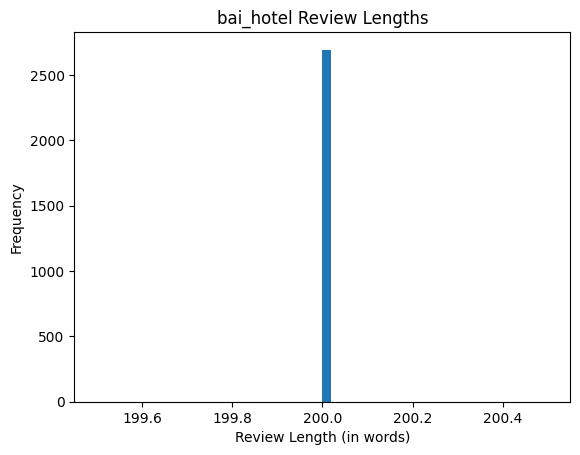

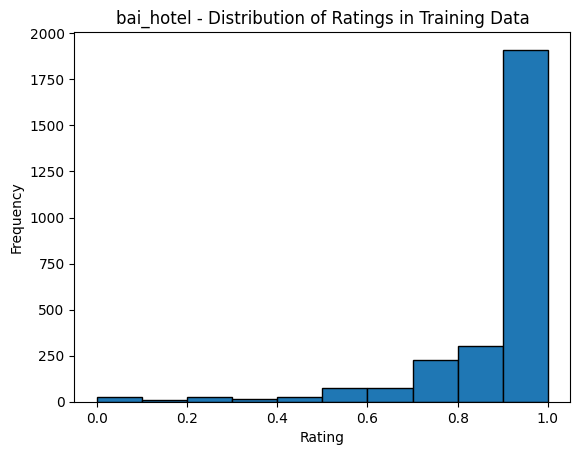

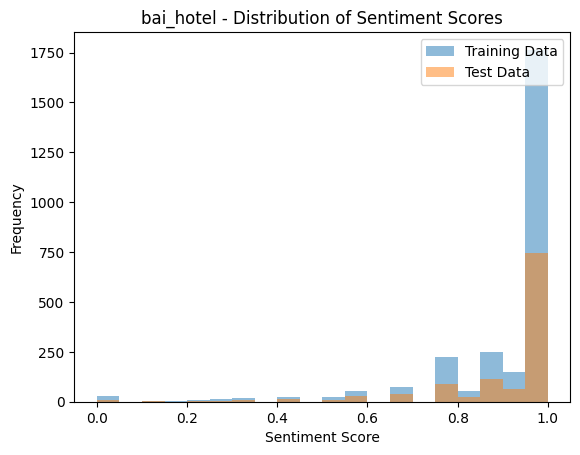

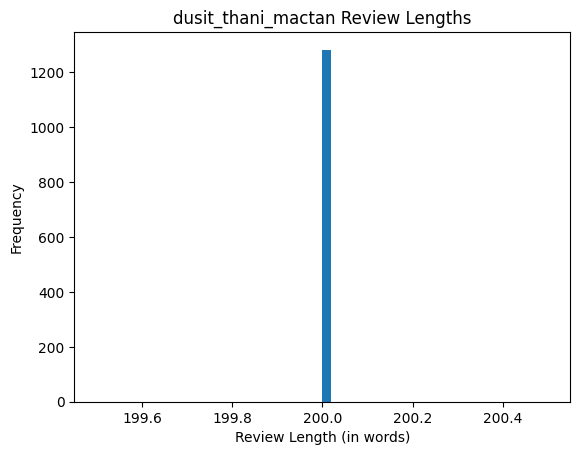

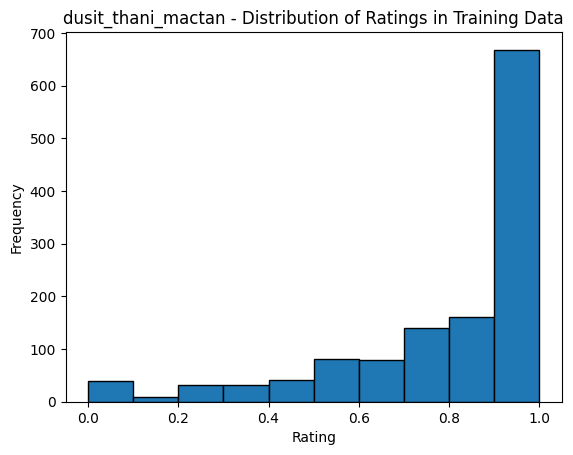

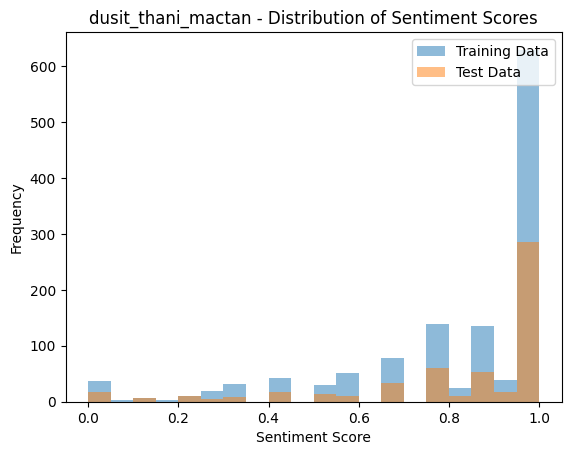

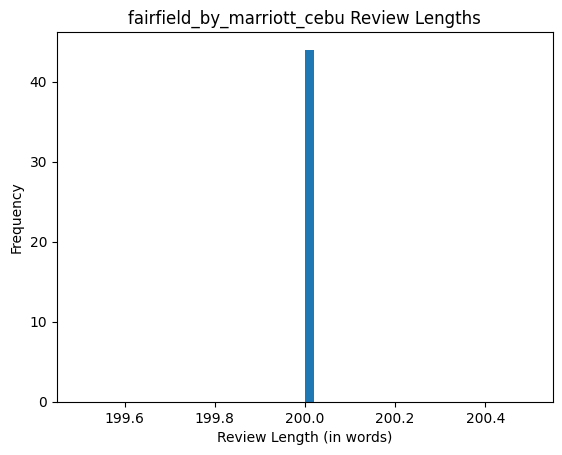

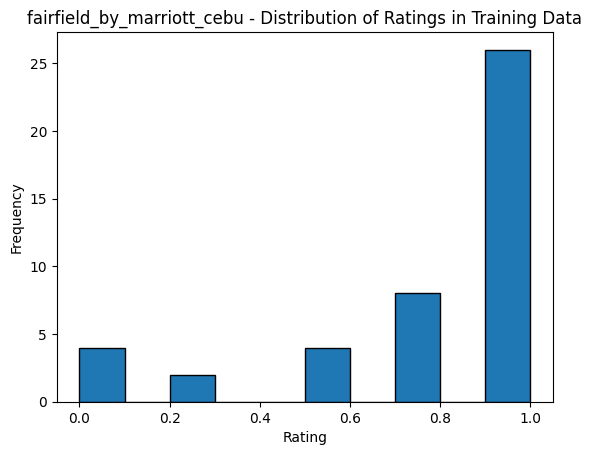

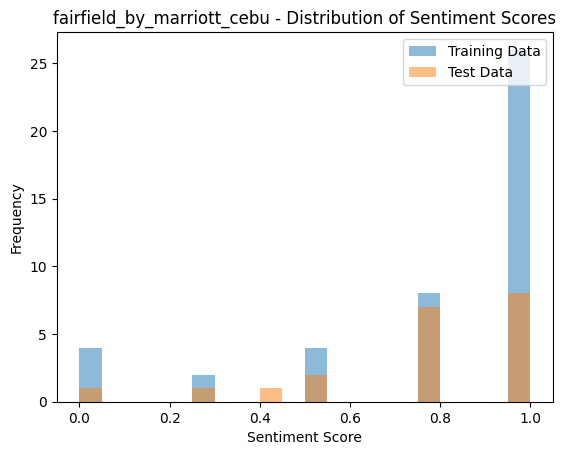

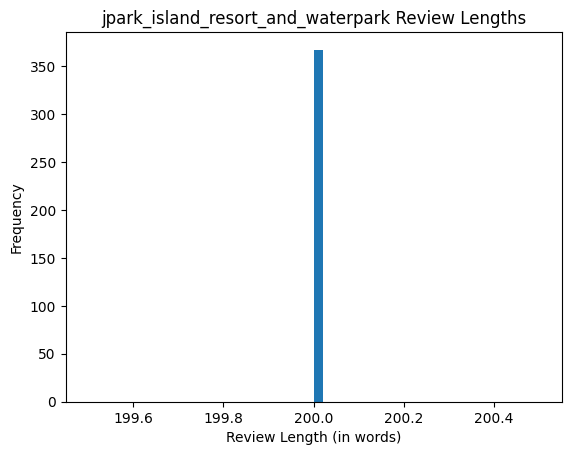

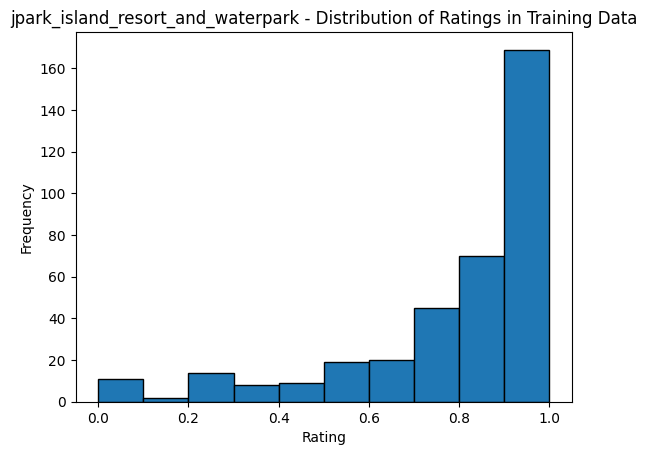

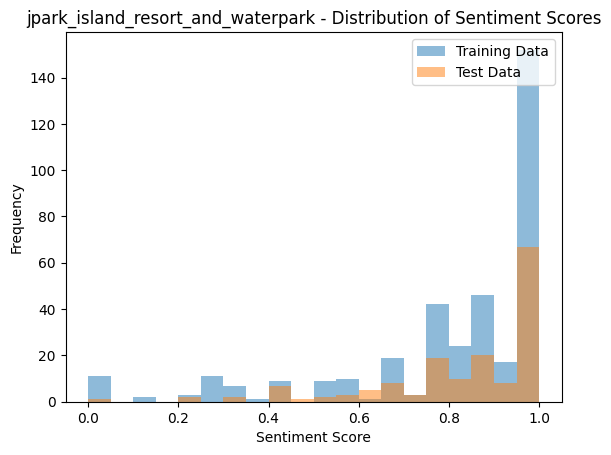

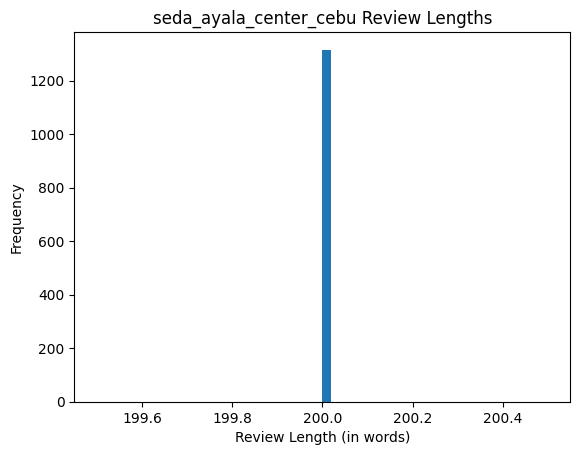

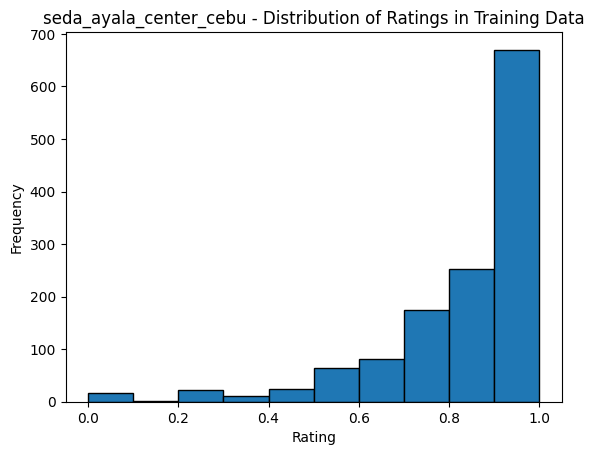

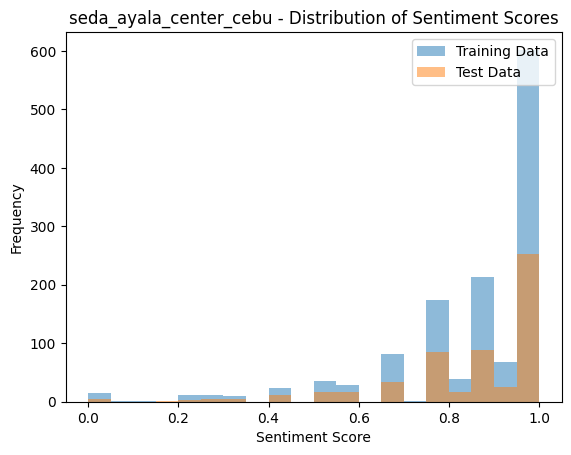

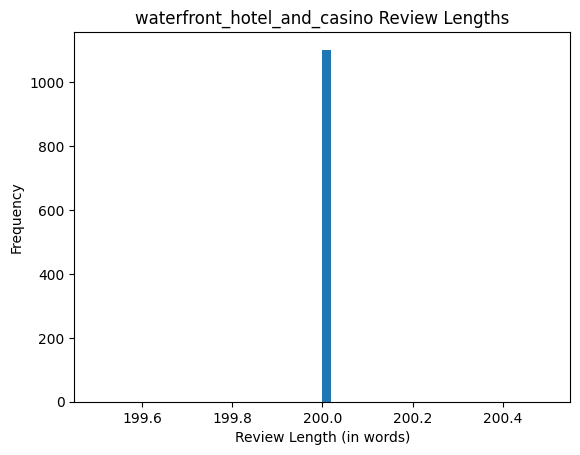

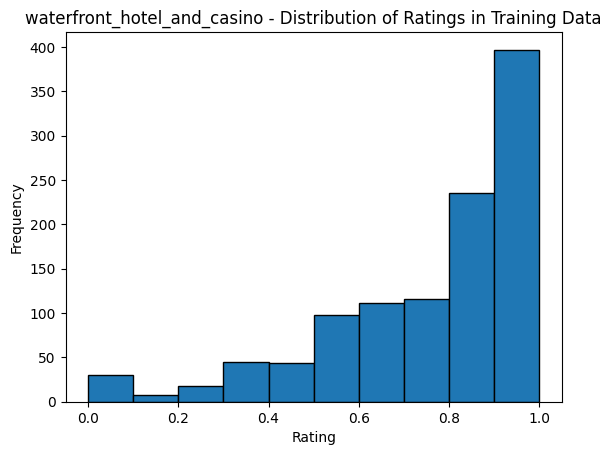

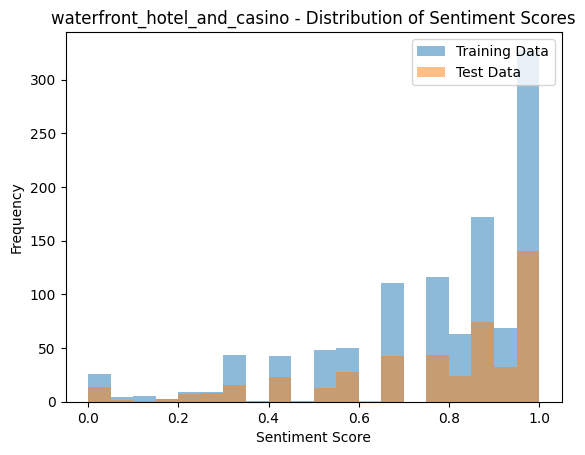

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the base path for datasets
base_output_path = os.path.join('..', 'datasets')

# List of hotel folders and their corresponding names for the EDA plots
hotel_folders = {
    '1_bai_hotel': 'bai_hotel',
    '2_dusit_thani_mactan': 'dusit_thani_mactan',
    '3_fairfield_by_marriott_cebu': 'fairfield_by_marriott_cebu',
    '4_jpark_island_resort_and_waterpark': 'jpark_island_resort_and_waterpark',
    '5_seda_ayala_center_cebu': 'seda_ayala_center_cebu',
    '6_waterfront_hotel_and_casino': 'waterfront_hotel_and_casino'
}

for folder, hotel_name in hotel_folders.items():
    output_folder = os.path.join(base_output_path, folder)
    
    # Load the preprocessed data
    data_path = os.path.join(output_folder, f"{hotel_name}_preprocessed_reviews.npz")
    data = np.load(data_path)
    
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # # For EDA purposes only
    # # Review lengths
    # review_lengths = [len(review) for review in x_train]
    # plt.hist(review_lengths, bins=50)
    # plt.title(f'{hotel_name} Review Lengths')
    # plt.xlabel('Review Length (in words)')
    # plt.ylabel('Frequency')
    # plt.show()
    
    # # Distribution of Ratings in Training Data
    # plt.hist(y_train, bins=10, edgecolor='k')
    # plt.title(f"{hotel_name} - Distribution of Ratings in Training Data")
    # plt.xlabel("Rating")
    # plt.ylabel("Frequency")
    # plt.show()
    
    # # Distribution of Sentiment Scores
    # plt.hist(y_train, bins=20, alpha=0.5, label='Training Data')
    # plt.hist(y_test, bins=20, alpha=0.5, label='Test Data')
    # plt.legend(loc='upper right')
    # plt.title(f'{hotel_name} - Distribution of Sentiment Scores')
    # plt.xlabel('Sentiment Score')
    # plt.ylabel('Frequency')
    # plt.show()

## Positive & Negative Counts
#### to test for overfitting or underfitting check

In [4]:
import numpy as np

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and count sentiment labels
def count_sentiments(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)

        y_labels = data['y_labels']  # Assuming y_labels contains sentiment labels

        positive_count = np.sum(y_labels == 1)
        negative_count = np.sum(y_labels == -1)
        neutral_count = np.sum(y_labels == 0)

        print(f"Hotel: {hotel_name}")
        print(f"Positive reviews: {positive_count}")
        print(f"Negative reviews: {negative_count}")
        print(f"Neutral reviews: {neutral_count}")
        print(f"Total reviews: {len(y_labels)}")
        print("-" * 50)

    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Count and display sentiments for each hotel
for hotel in hotels:
    count_sentiments(hotel)

Hotel: bai_hotel
Positive reviews: 3472
Negative reviews: 81
Neutral reviews: 295
Total reviews: 3848
--------------------------------------------------
Hotel: dusit_thani_mactan
Positive reviews: 1397
Negative reviews: 118
Neutral reviews: 317
Total reviews: 1832
--------------------------------------------------
Hotel: fairfield_by_marriott_cebu
Positive reviews: 49
Negative reviews: 8
Neutral reviews: 7
Total reviews: 64
--------------------------------------------------
Hotel: jpark_island_resort_and_waterpark
Positive reviews: 405
Negative reviews: 29
Neutral reviews: 91
Total reviews: 525
--------------------------------------------------
Hotel: seda_ayala_center_cebu
Positive reviews: 1563
Negative reviews: 53
Neutral reviews: 265
Total reviews: 1881
--------------------------------------------------
Hotel: waterfront_hotel_and_casino
Positive reviews: 1062
Negative reviews: 91
Neutral reviews: 422
Total reviews: 1575
--------------------------------------------------


# General Sentiment Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(





Training the CNN-biLSTM model for Hotel bai_hotel...
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.6169 - loss: 0.2679 - val_accuracy: 0.7222 - val_loss: 0.2543
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6277 - loss: 0.1869 - val_accuracy: 0.7259 - val_loss: 0.2213
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6466 - loss: 0.1627 - val_accuracy: 0.7296 - val_loss: 0.2316
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6469 - loss: 0.1506 - val_accuracy: 0.7333 - val_loss: 0.2325
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6665 - loss: 0.1382 - val_accuracy: 0.7296 - val_loss: 0.2420
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6612 - loss: 0.1354 - val_accuracy: 0.7296 - val_loss: 0.2521
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6590 - loss: 0.1315 - val_accuracy: 0.7333 - val_loss: 0.2608
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - a

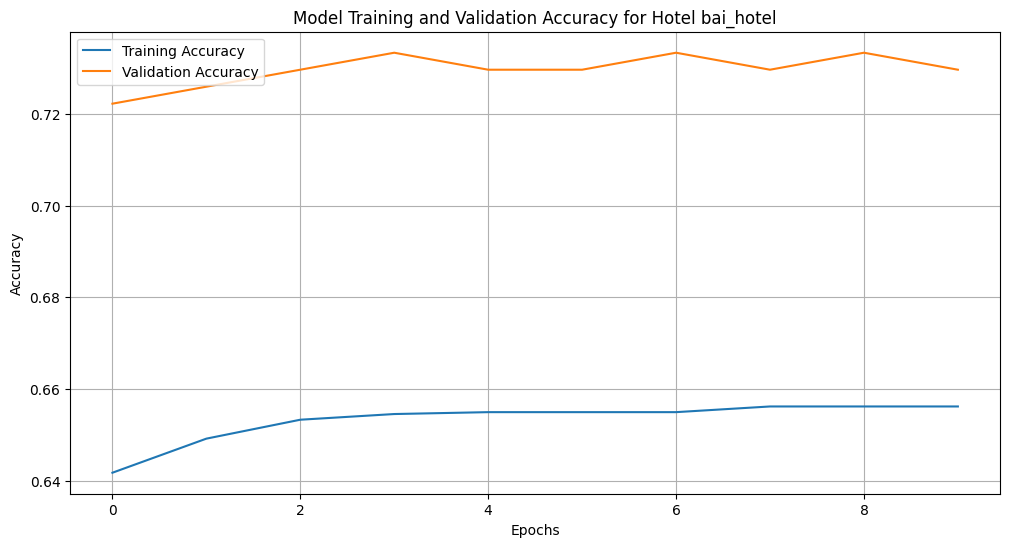

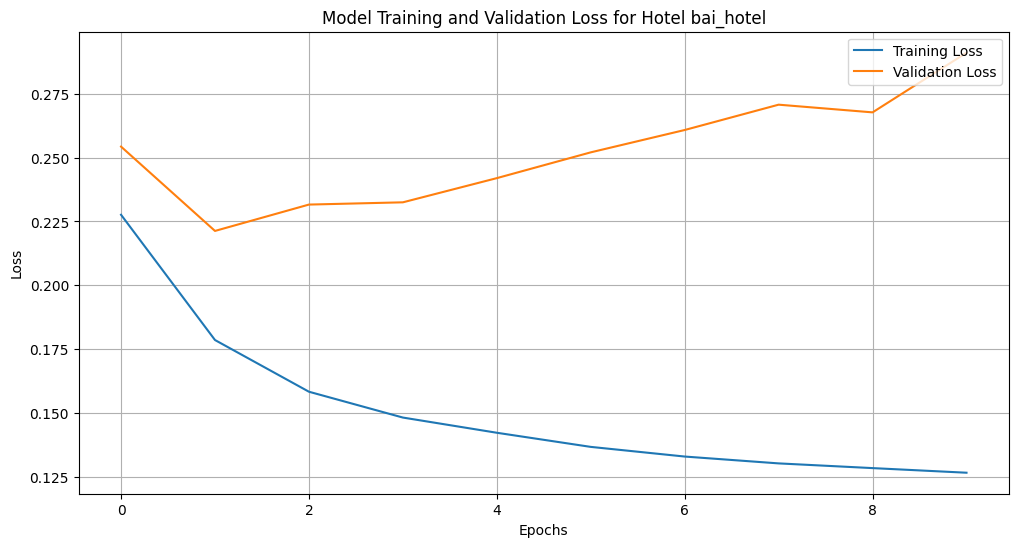

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6318 - loss: 0.3568
Test Loss for Hotel bai_hotel: 0.36234742403030396
Test Accuracy for Hotel bai_hotel: 0.6441558599472046
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

Classification Report for Hotel bai_hotel:
              precision    recall  f1-score   support

    Negative       0.40      0.07      0.12        55
    Positive       0.96      0.99      0.97      1100

    accuracy                           0.95      1155
   macro avg       0.68      0.53      0.55      1155
weighted avg       0.93      0.95      0.93      1155



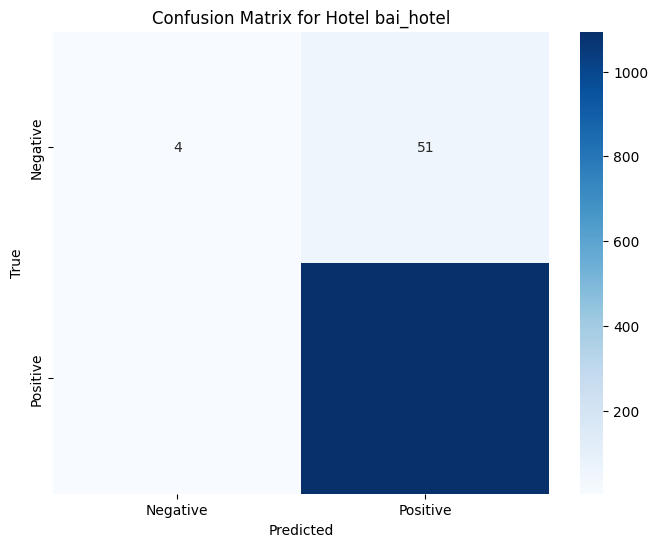

Mean Squared Error for Hotel bai_hotel: 0.02651100319502809
Predicted sentiment values for Hotel bai_hotel saved in ../predictions/1_bai_hotel



Training the CNN-biLSTM model for Hotel dusit_thani_mactan...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.4541 - loss: 0.4460 - val_accuracy: 0.5039 - val_loss: 0.4320
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4749 - loss: 0.3730 - val_accuracy: 0.5039 - val_loss: 0.3858
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5094 - loss: 0.2877 - val_accuracy: 0.5116 - val_loss: 0.4040
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5162 - loss: 0.2628 - val_accuracy: 0.5116 - val_loss: 0.3906
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.4900 - loss: 0.2641 - val_accuracy: 0.5116 - val_loss: 0.3992
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5233 - loss: 0.2457 - val_accuracy: 0.5116 - val_loss: 0.4153
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5097 - loss: 0.2473 - val_accuracy: 0.5116 - val_loss: 0.4251
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5050 - loss: 0.2493 - val_accuracy: 0.5116 - val_loss: 0.

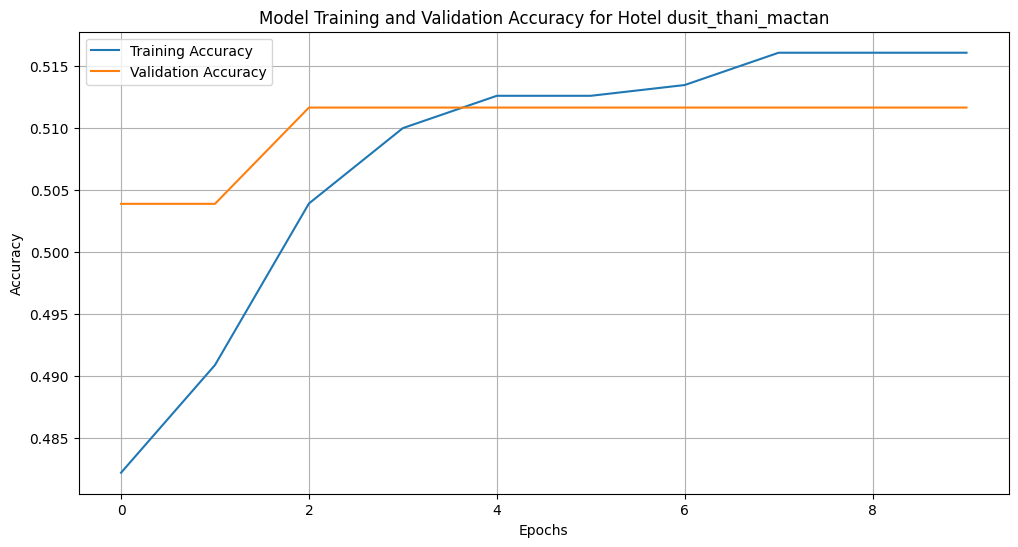

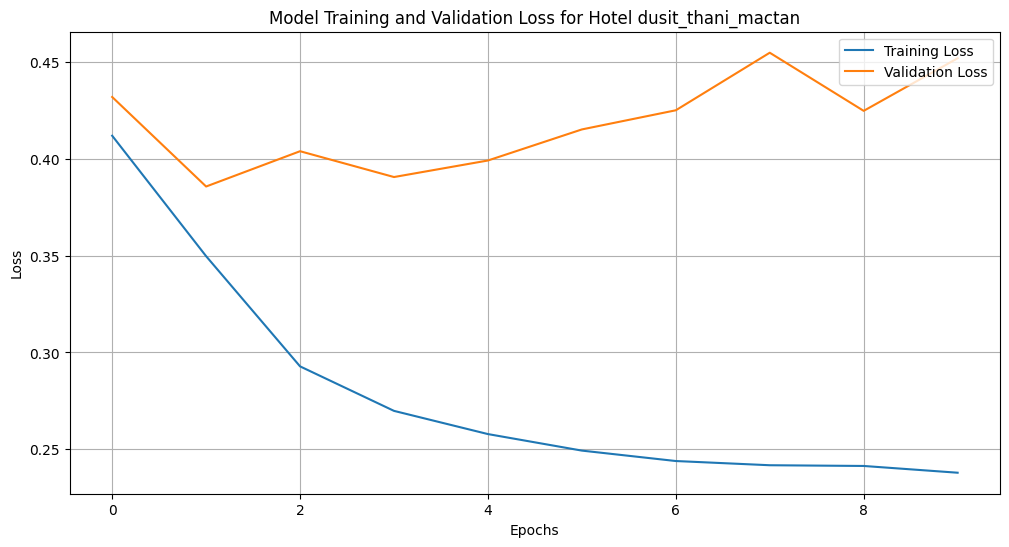

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5473 - loss: 0.3877
Test Loss for Hotel dusit_thani_mactan: 0.40596452355384827
Test Accuracy for Hotel dusit_thani_mactan: 0.5254545211791992
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Classification Report for Hotel dusit_thani_mactan:
              precision    recall  f1-score   support

    Negative       0.57      0.21      0.30        77
    Positive       0.88      0.97      0.93       473

    accuracy                           0.87       550
   macro avg       0.73      0.59      0.62       550
weighted avg       0.84      0.87      0.84       550



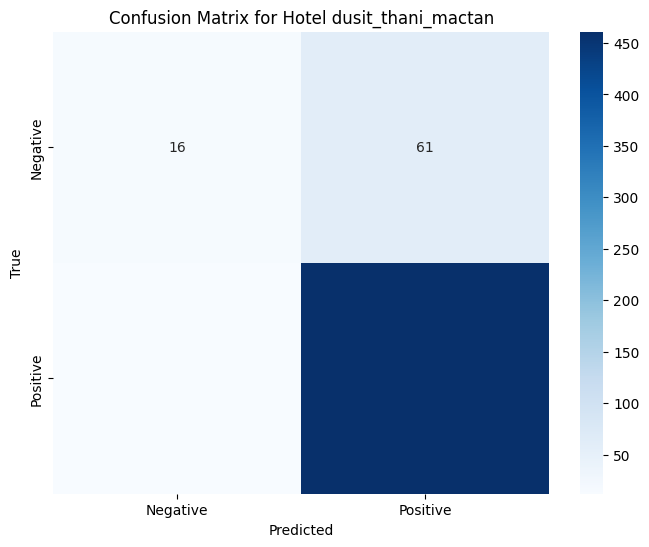

Mean Squared Error for Hotel dusit_thani_mactan: 0.04671431681489242
Predicted sentiment values for Hotel dusit_thani_mactan saved in ../predictions/2_dusit_thani_mactan



Training the CNN-biLSTM model for Hotel fairfield_by_marriott_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step - accuracy: 0.1509 - loss: 0.5440 - val_accuracy: 0.4000 - val_loss: 0.5417
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5978 - loss: 0.3951 - val_accuracy: 0.4000 - val_loss: 0.6562
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6082 - loss: 0.4649 - val_accuracy: 0.4000 - val_loss: 0.6280
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5978 - loss: 0.4555 - val_accuracy: 0.4000 - val_loss: 0.5097
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6082 - loss: 0.3561 - val_accuracy: 0.4000 - val_loss: 0.5030
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5978 - loss: 0.3660 - val_accuracy: 0.4000 - val_loss: 0.5028
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6290 - loss: 0.3464 - val_accuracy: 0.4000 - val_loss: 0.5070
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6394 - loss: 0.3268 - val_accuracy: 0.4000 - val_loss: 0.5057
Epoch 9/10

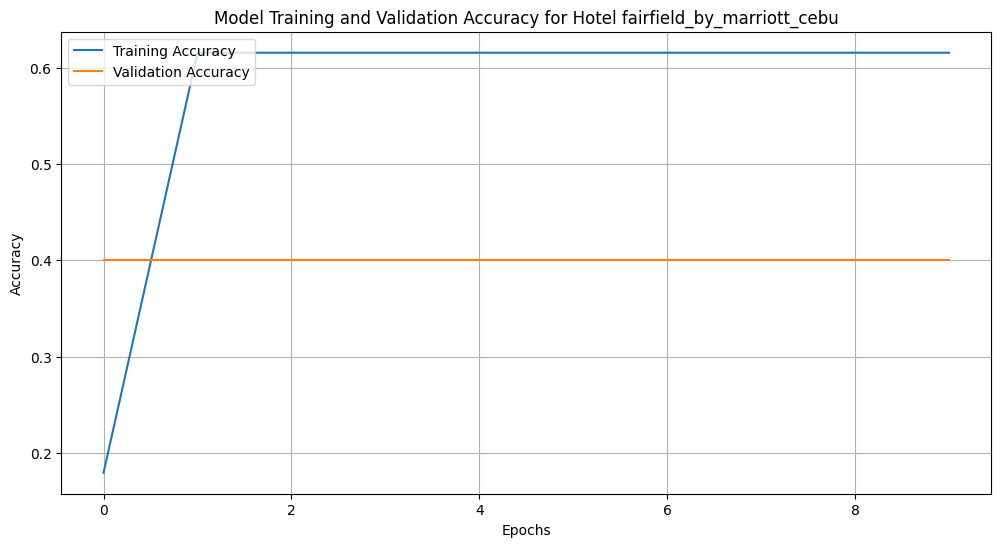

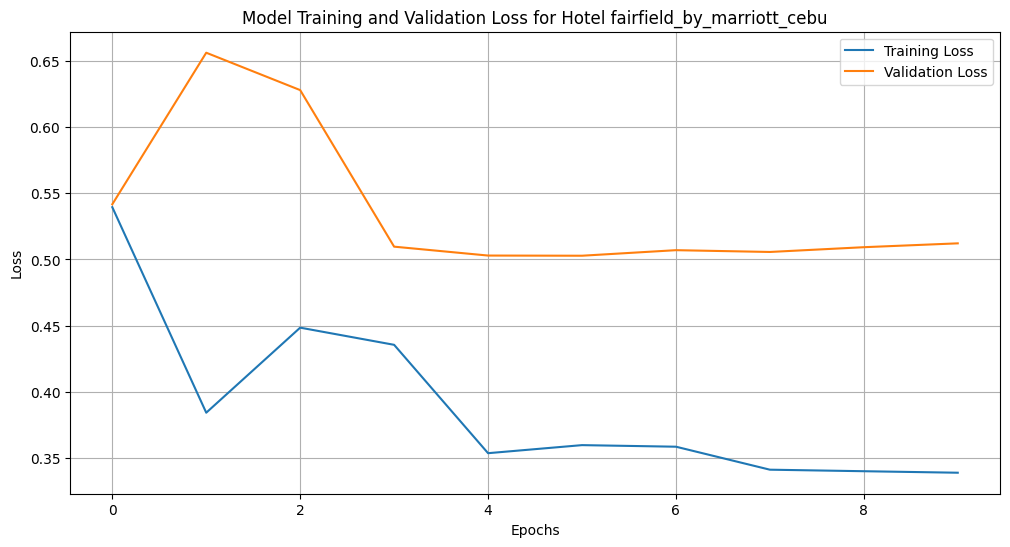

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4000 - loss: 0.5738
Test Loss for Hotel fairfield_by_marriott_cebu: 0.5738285779953003
Test Accuracy for Hotel fairfield_by_marriott_cebu: 0.4000000059604645
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step

Classification Report for Hotel fairfield_by_marriott_cebu:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         5
    Positive       0.75      1.00      0.86        15

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

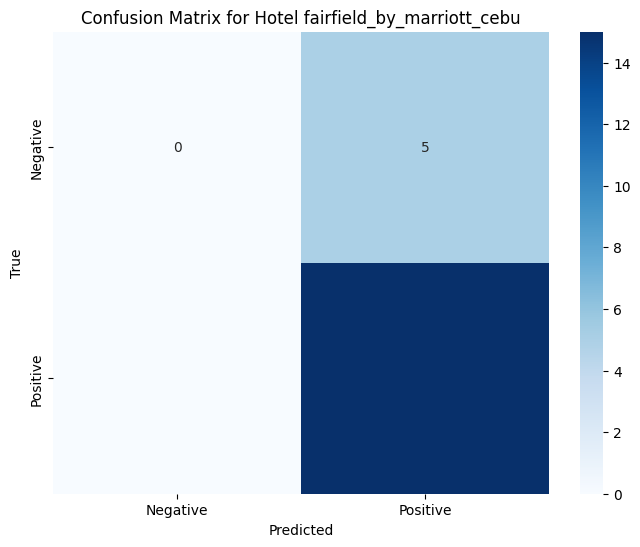

Mean Squared Error for Hotel fairfield_by_marriott_cebu: 0.083217396222105
Predicted sentiment values for Hotel fairfield_by_marriott_cebu saved in ../predictions/3_fairfield_by_marriott_cebu



Training the CNN-biLSTM model for Hotel jpark_island_resort_and_waterpark...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.3071 - loss: 0.6442 - val_accuracy: 0.4595 - val_loss: 0.4407
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3435 - loss: 0.5105 - val_accuracy: 0.4595 - val_loss: 0.4382
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3851 - loss: 0.4975 - val_accuracy: 0.4595 - val_loss: 0.4333
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3649 - loss: 0.5091 - val_accuracy: 0.4595 - val_loss: 0.4436
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3723 - loss: 0.4687 - val_accuracy: 0.4595 - val_loss: 0.4412
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3757 - loss: 0.4526 - val_accuracy: 0.4595 - val_loss: 0.4482
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3632 - loss: 0.4323 - val_accuracy: 0.4595 - val_loss: 0.4299
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3793 - loss: 0.4170 - val_accuracy: 0.4595 - val_loss: 0

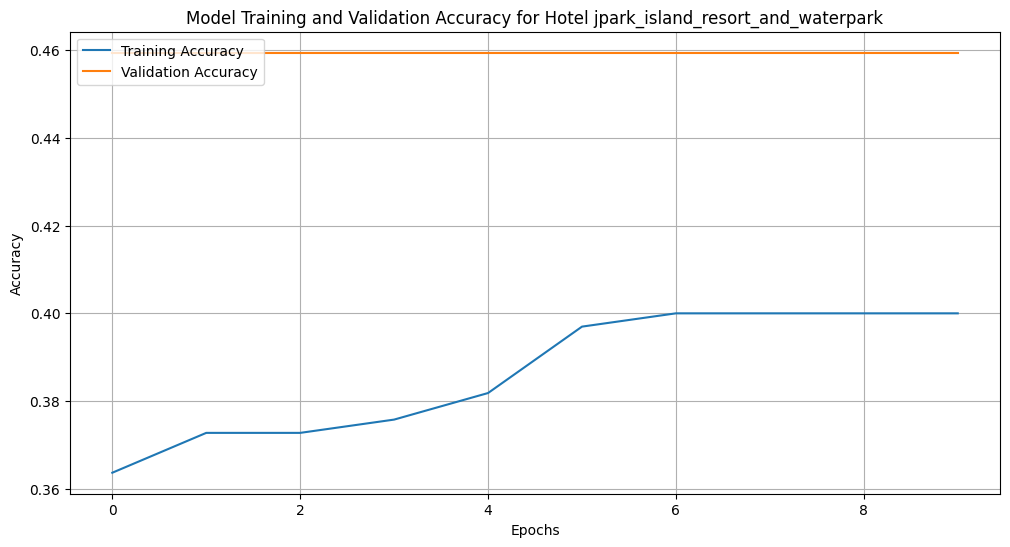

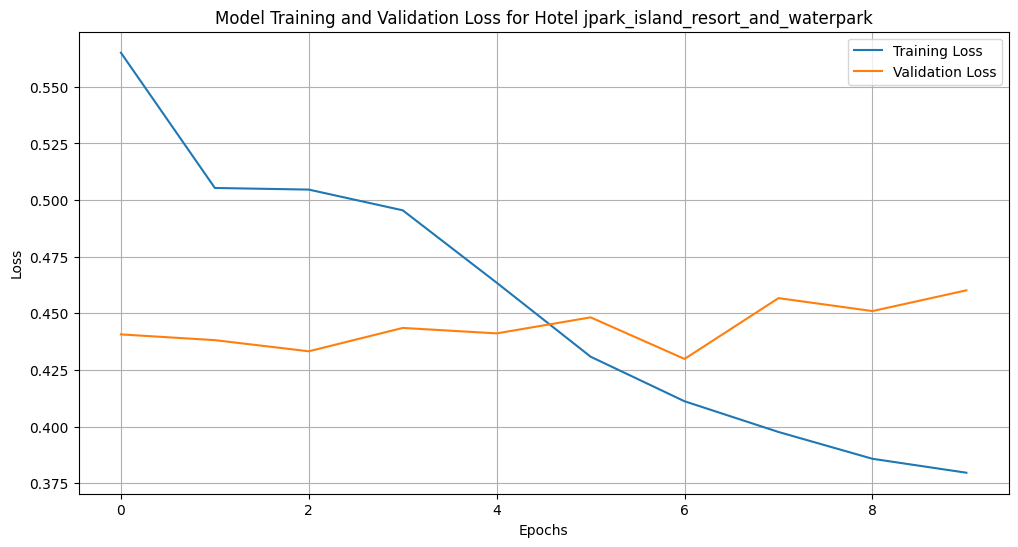

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4017 - loss: 0.3887
Test Loss for Hotel jpark_island_resort_and_waterpark: 0.4111078977584839
Test Accuracy for Hotel jpark_island_resort_and_waterpark: 0.3860759437084198
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step WARNING:tensorflow:5 out of the last 24 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024610D68720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━

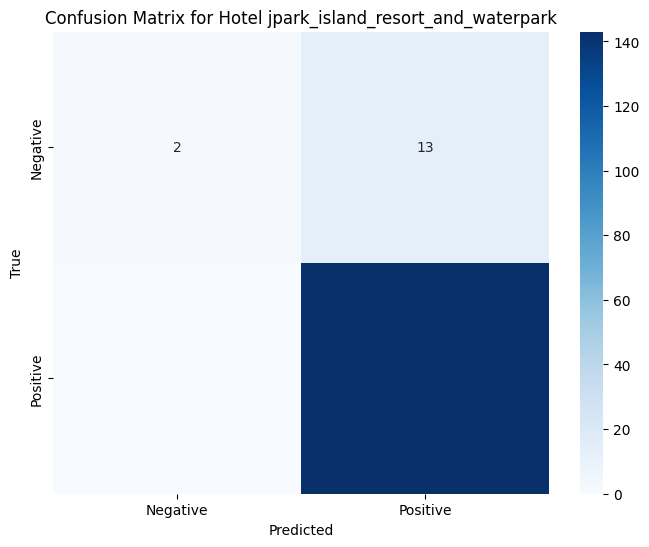

Mean Squared Error for Hotel jpark_island_resort_and_waterpark: 0.029336171054714998
Predicted sentiment values for Hotel jpark_island_resort_and_waterpark saved in ../predictions/4_jpark_island_resort_and_waterpark



Training the CNN-biLSTM model for Hotel seda_ayala_center_cebu...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.4461 - loss: 0.4814 - val_accuracy: 0.4394 - val_loss: 0.3825
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4365 - loss: 0.3927 - val_accuracy: 0.4394 - val_loss: 0.3605
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4621 - loss: 0.3358 - val_accuracy: 0.4394 - val_loss: 0.3620
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4635 - loss: 0.3134 - val_accuracy: 0.4394 - val_loss: 0.3583
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.4542 - loss: 0.3118 - val_accuracy: 0.4394 - val_loss: 0.3743
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4627 - loss: 0.2894 - val_accuracy: 0.4394 - val_loss: 0.3783
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4842 - loss: 0.2811 - val_accuracy: 0.4394 - val_loss: 0.3736
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4677 - loss: 0.2824 - val_accuracy: 0.4394 - val_loss: 0.

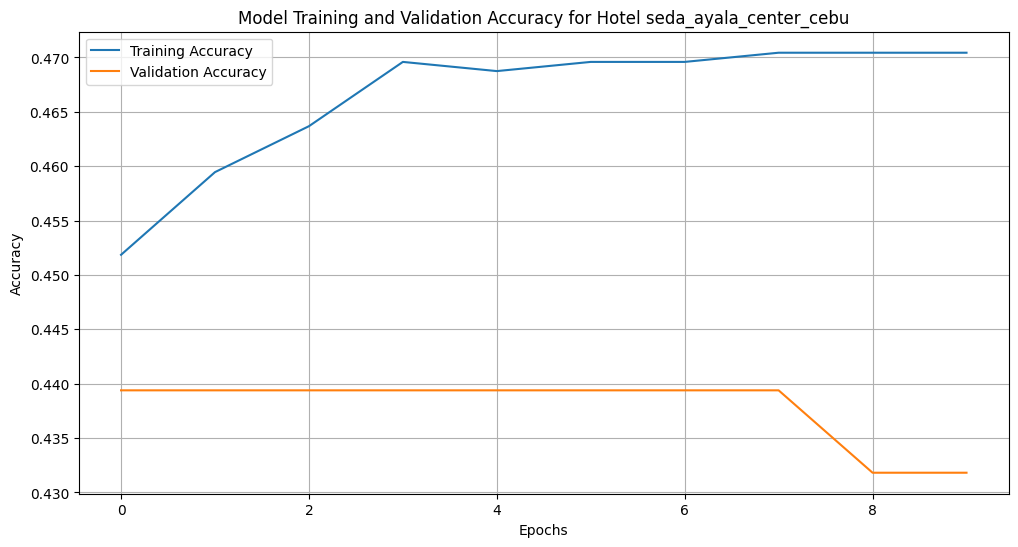

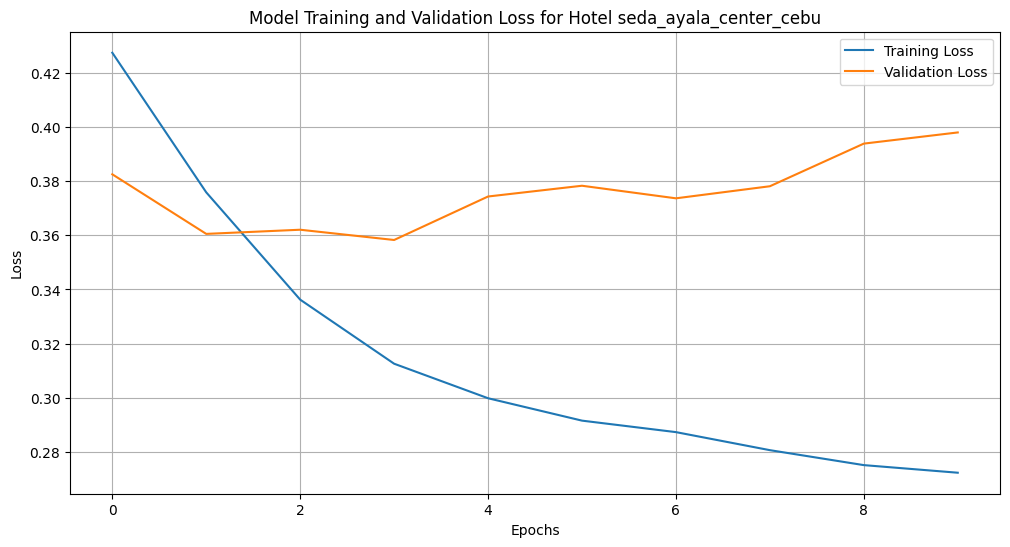

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4539 - loss: 0.4429
Test Loss for Hotel seda_ayala_center_cebu: 0.4567309319972992
Test Accuracy for Hotel seda_ayala_center_cebu: 0.4407079517841339
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step

Classification Report for Hotel seda_ayala_center_cebu:
              precision    recall  f1-score   support

    Negative       0.33      0.17      0.23        47
    Positive       0.93      0.97      0.95       518

    accuracy                           0.90       565
   macro avg       0.63      0.57      0.59       565
weighted avg       0.88      0.90      0.89       565



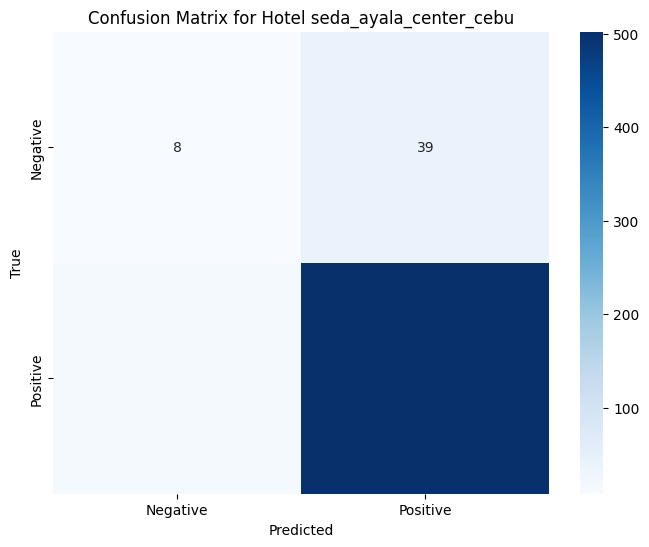

Mean Squared Error for Hotel seda_ayala_center_cebu: 0.03645071076066257
Predicted sentiment values for Hotel seda_ayala_center_cebu saved in ../predictions/5_seda_ayala_center_cebu



Training the CNN-biLSTM model for Hotel waterfront_hotel_and_casino...


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.3061 - loss: 0.7543 - val_accuracy: 0.3514 - val_loss: 0.5301
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3164 - loss: 0.6597 - val_accuracy: 0.3514 - val_loss: 0.5192
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.3063 - loss: 0.6352 - val_accuracy: 0.3694 - val_loss: 0.4848
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.3086 - loss: 0.5733 - val_accuracy: 0.3694 - val_loss: 0.4773
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3253 - loss: 0.5637 - val_accuracy: 0.3604 - val_loss: 0.4738
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.2959 - loss: 0.5458 - val_accuracy: 0.3604 - val_loss: 0.5027
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.2980 - loss: 0.5357 - val_accuracy: 0.3694 - val_loss: 0.4718
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.2930 - loss: 0.5283 - val_accuracy: 0.3694 -

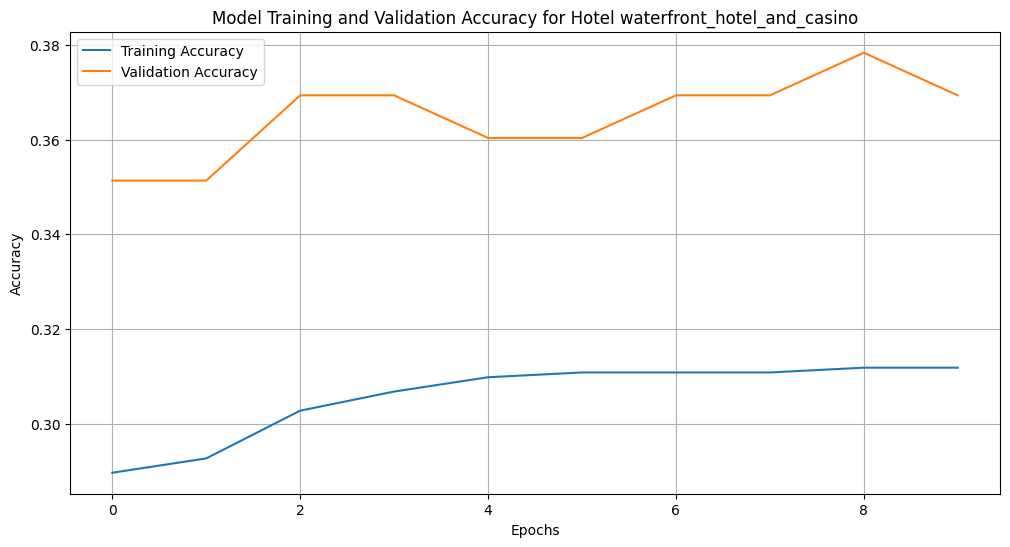

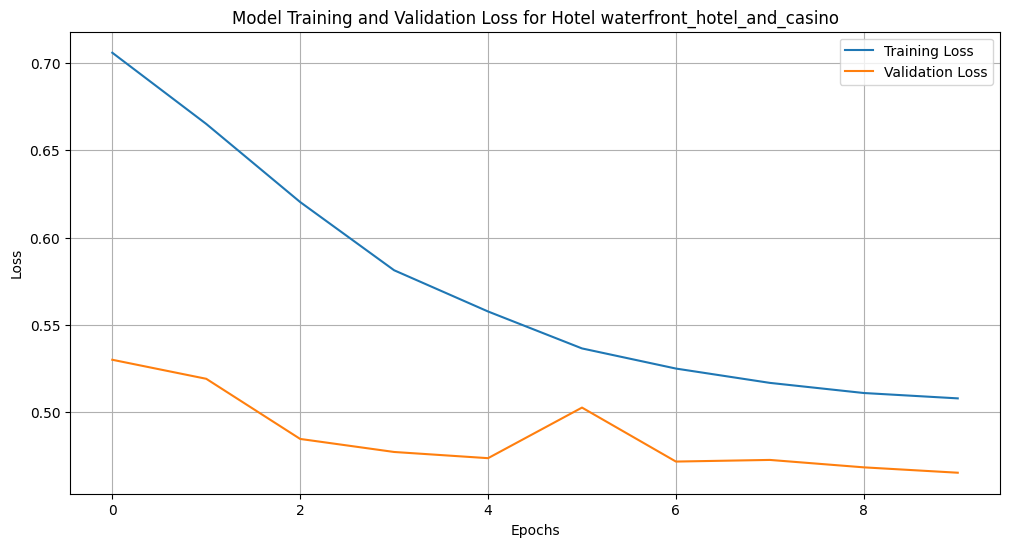

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3061 - loss: 0.5080
Test Loss for Hotel waterfront_hotel_and_casino: 0.4977864623069763
Test Accuracy for Hotel waterfront_hotel_and_casino: 0.3086680769920349
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

Classification Report for Hotel waterfront_hotel_and_casino:
              precision    recall  f1-score   support

    Negative       0.57      0.26      0.36        87
    Positive       0.85      0.96      0.90       386

    accuracy                           0.83       473
   macro avg       0.71      0.61      0.63       473
weighted avg       0.80      0.83      0.80       473



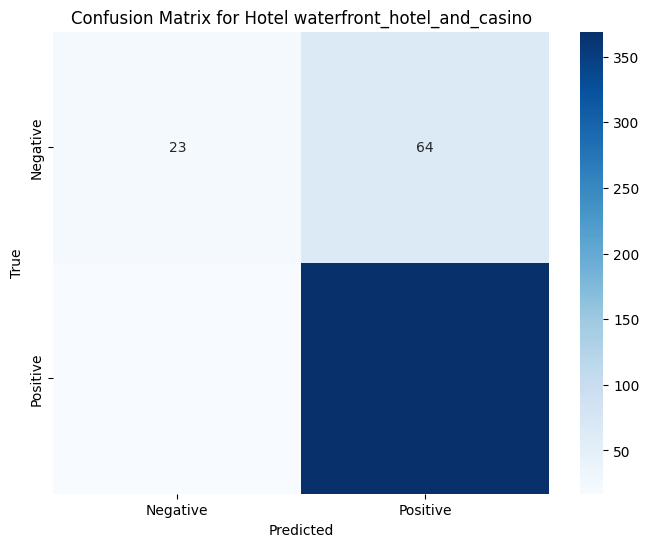

Mean Squared Error for Hotel waterfront_hotel_and_casino: 0.048304717600321734
Predicted sentiment values for Hotel waterfront_hotel_and_casino saved in ../predictions/6_waterfront_hotel_and_casino


In [5]:
import numpy as np
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200
BATCH_SIZE = 32
EPOCHS = 10

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Map hotel names to their respective folder names
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Load preprocessed data for a single hotel
def load_data(hotel_name):
    try:
        folder_name = hotel_folder_mapping[hotel_name]
        data_path = f"../datasets/{folder_name}/{hotel_name}_preprocessed_reviews.npz"
        data = np.load(data_path)
        return data
    except Exception as e:
        print(f"Error loading data for {hotel_name}: {e}")
        return None

# Train and evaluate the model for a single hotel
def train_and_evaluate_model(x_train, x_test, y_train, y_test, label):
    try:
        input_text = Input(shape=(MAX_SEQUENCE_LENGTH,))
        embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_text)
        conv1d = Conv1D(128, 5, activation='relu')(embedding)
        maxpool = MaxPooling1D(2)(conv1d)
        bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(maxpool)
        dropout = Dropout(0.5)(bi_lstm)
        flat = Flatten()(dropout)
        output = Dense(1, activation='sigmoid')(flat)
        model = Model(inputs=input_text, outputs=output)

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print(f"\n\n\nTraining the CNN-biLSTM model for {label}...")
        
        # Calculate class weights
        class_weights = {0: len(y_train) / (2 * np.bincount(y_train == 0)[0]), 
                        1: len(y_train) / (2 * np.bincount(y_train == 1)[1])}

        # Train the model with class weights
        history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, class_weight=class_weights)

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Training and Validation Accuracy for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training and Validation Loss for {label}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        loss, accuracy = model.evaluate(x_test, y_test)
        print(f"Test Loss for {label}: {loss}")
        print(f"Test Accuracy for {label}: {accuracy}")

        y_pred_prob = model.predict(x_test)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Ensure y_test is binary for classification report
        y_test_binary = (y_test > 0.5).astype(int)

        print(f"\nClassification Report for {label}:")
        print(classification_report(y_test_binary, y_pred, target_names=['Negative', 'Positive']))

        conf_matrix = confusion_matrix(y_test_binary, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

        # Evaluate regression metrics for continuous predictions
        mse = mean_squared_error(y_test, y_pred_prob)
        print(f"Mean Squared Error for {label}: {mse}")

        # Save and print the predicted sentiment values
        output_folder = f"../predictions/{hotel_folder_mapping[label.split()[1]]}"
        os.makedirs(output_folder, exist_ok=True)
        np.savez_compressed(os.path.join(output_folder, f"{label}_predictions.npz"), y_pred_prob=y_pred_prob)
        print(f"Predicted sentiment values for {label} saved in {output_folder}")

    except Exception as e:
        print(f"Error during training and evaluation for {label}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Perform sentiment analysis for each hotel
for hotel in hotels:
    data = load_data(hotel)
    if data is not None:
        x_train, x_test, y_train, y_test = data['x_train'], data['x_test'], data['y_train'], data['y_test']
        train_and_evaluate_model(x_train, x_test, y_train, y_test, f'Hotel {hotel}')
    else:
        print(f"Skipping sentiment analysis for {hotel} due to data loading error.")

        
###! GENERAL ANALYSIS OF RESULTS: 
# ! 1. potential overfitting : the imbalance is likely causing the model to be biased towards predicting the positive class
# ! 2. the model correctly identifies the positive samples almost all the time but struggles significantly with the negative samples
# ! 3. class imbalance is a significant issue in the dataset, and the model is not able to generalize well to the negative class

###* Addressing Class Imbalance
# * 1. oversampling the minority class (negative reviews) using techniques like SMOTE
# * 2. undersampling the majority class (positive reviews)
# * 3. using class weights during training to penalize misclassifications in the minority class
# * 4. using a different evaluation metric like F1-score or AUC-ROC that is less sensitive to class imbalance

## Loading of predicted values

In [6]:
import numpy as np
import os

# List of hotels and their respective folders
hotel_folder_mapping = {
    'bai_hotel': '1_bai_hotel',
    'dusit_thani_mactan': '2_dusit_thani_mactan',
    'fairfield_by_marriott_cebu': '3_fairfield_by_marriott_cebu',
    'jpark_island_resort_and_waterpark': '4_jpark_island_resort_and_waterpark',
    'seda_ayala_center_cebu': '5_seda_ayala_center_cebu',
    'waterfront_hotel_and_casino': '6_waterfront_hotel_and_casino'
}

# Function to load and print predicted values
def load_and_print_predictions(hotel_name):
    folder_name = hotel_folder_mapping[hotel_name]
    prediction_path = f"../predictions/{folder_name}/Hotel {hotel_name}_predictions.npz"
    
    try:
        data = np.load(prediction_path)
        y_pred_prob = data['y_pred_prob']
        print(f"Predicted sentiment values for {hotel_name}:\n{y_pred_prob}")
    except Exception as e:
        print(f"Error loading predictions for {hotel_name}: {e}")

# List of hotels
hotels = ['bai_hotel', 'dusit_thani_mactan', 'fairfield_by_marriott_cebu', 'jpark_island_resort_and_waterpark', 'seda_ayala_center_cebu', 'waterfront_hotel_and_casino']

# Load and print predictions for each hotel
for hotel in hotels:
    load_and_print_predictions(hotel)
    
#* NOTE: these are the predicted sentiment value of EACH review

Predicted sentiment values for bai_hotel:
[[0.93573856]
 [0.6786188 ]
 [0.9934087 ]
 ...
 [0.9995678 ]
 [0.9994022 ]
 [0.99158883]]
Predicted sentiment values for dusit_thani_mactan:
[[0.6854444 ]
 [0.9699294 ]
 [0.9999594 ]
 [0.937049  ]
 [0.99996316]
 [0.95692   ]
 [0.9311055 ]
 [0.76565385]
 [0.7301127 ]
 [0.81026214]
 [0.9950801 ]
 [0.9705549 ]
 [0.9910242 ]
 [0.89236635]
 [0.8846637 ]
 [0.96449935]
 [0.82075226]
 [0.697083  ]
 [0.9999481 ]
 [0.98273057]
 [0.99861753]
 [0.9992071 ]
 [0.9823408 ]
 [0.65223825]
 [0.9662854 ]
 [0.99839556]
 [0.8920047 ]
 [0.9954724 ]
 [0.6978602 ]
 [0.856033  ]
 [0.9996968 ]
 [0.9774231 ]
 [0.9694008 ]
 [0.9964098 ]
 [0.9789319 ]
 [0.91150534]
 [0.9983429 ]
 [0.99993473]
 [0.8619333 ]
 [0.81097263]
 [0.91965634]
 [0.45881984]
 [0.5686474 ]
 [0.8243907 ]
 [0.9960591 ]
 [0.9998253 ]
 [0.79023135]
 [0.8999032 ]
 [0.7133308 ]
 [0.96646535]
 [0.63010687]
 [0.69051194]
 [0.56314266]
 [0.57532454]
 [0.9999589 ]
 [0.9216146 ]
 [0.99996513]
 [0.9999484 ]
 [0.9

# Aspect-based Sentiment Analysis

In [ ]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model

# Constants
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 200

# Load Aspect-Based Dataset from multiple CSV files
aspect_path = r"C:\Users\andyb\Desktop\Coding Files\PointView\datasets\aspect-based\*.csv"
all_files = glob.glob(aspect_path)

# Initial empty DataFrame
aspect_data = pd.DataFrame()

# Load and unify all CSV files
for file in all_files:
    df = pd.read_csv(file)
    # Rename columns if necessary or handle missing 'Labels' column
    if 'Labels' not in df.columns:
        # Example: Assuming the column might be named 'Classification' instead
        if 'Classification' in df.columns:
            df.rename(columns={'Classification': 'Labels'}, inplace=True)
        else:
            df['Labels'] = None  # or df['Labels'] = 'default_value' if appropriate
    aspect_data = pd.concat([aspect_data, df], ignore_index=True)

# Check if 'Labels' column is properly set up
print(aspect_data.columns)

# Prepare Aspect Data
mlb = MultiLabelBinarizer()
aspect_data['Labels'] = aspect_data['Labels'].fillna('')  # Handle None or missing labels
aspect_data['Labels'] = aspect_data['Labels'].apply(lambda x: x.split(':'))
labels = mlb.fit_transform(aspect_data['Labels'])

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(aspect_data['Opinion'])  # Assuming 'Opinion' column holds the text
sequences = tokenizer.texts_to_sequences(aspect_data['Opinion'])
aspect_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Split the aspect data
x_train_aspects, x_test_aspects, y_train_aspects, y_test_aspects = train_test_split(aspect_padded, labels, test_size=0.3, random_state=42)

# Define biLSTM model for Aspect-Based Analysis
input_aspect = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_aspect = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_aspect)
bi_lstm_aspect = Bidirectional(LSTM(64, return_sequences=False))(embedding_aspect)
output_aspect = Dense(len(mlb.classes_), activation='softmax')(bi_lstm_aspect)
aspect_model = Model(inputs=input_aspect, outputs=output_aspect)

# Compile and train aspect model
print("Training the Aspect-Based Analysis model...")
aspect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aspect_history = aspect_model.fit(x_train_aspects, y_train_aspects, epochs=10, batch_size=32, validation_split=0.1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['accuracy'], label='Train Accuracy')
plt.plot(aspect_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(aspect_history.history['loss'], label='Train Loss')
plt.plot(aspect_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Index(['Opinion', 'Labels'], dtype='object')
Training the Aspect-Based Analysis model...
Epoch 1/10


c:\Users\andyb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.2530 - loss: 4.6521 - val_accuracy: 0.4785 - val_loss: 5.5421
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4162 - loss: 5.7795 - val_accuracy: 0.4785 - val_loss: 5.9801
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3150 - loss: 6.1675 - val_accuracy: 0.0993 - val_loss: 6.3393
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2994 - loss: 6.4041 - val_accuracy: 0.0993 - val_loss: 6.7507
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.2733 - loss: 6.6940 - val_accuracy: 0.4785 - val_loss: 7.0802
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3462 - loss: 7.3290 - val_accuracy: 0.4785 - val_loss: 7.5129
Epoch 7/10
 37/170 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4698 - loss: 7.6051

KeyboardInterrupt: 

## KDE for each hotel

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


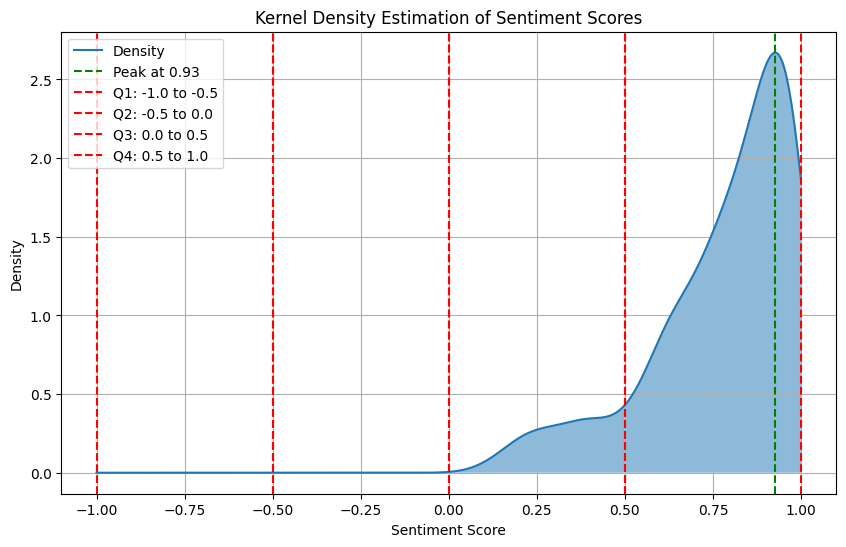

Peak value: 0.93
Quartiles: [(-1.0, -0.5), (-0.5, 0.0), (0.0, 0.5), (0.5, 1.0)]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tensorflow.keras.models import Model

y_pred = model.predict(x_test).flatten()  

# Define a function to plot KDE, identify peak, and fixed quartiles
def plot_kde_and_statistics(predictions, title="Sentiment Analysis Distribution"):
    plt.figure(figsize=(10, 6))
    kde = gaussian_kde(predictions)
    scores = np.linspace(-1, 1, 1000)  # fixed range for sentiment scores
    density = kde(scores)
    plt.plot(scores, density, label='Density')
    plt.fill_between(scores, density, alpha=0.5)

    # Identify peak
    peak = scores[np.argmax(density)]
    plt.axvline(x=peak, color='green', linestyle='--', label=f'Peak at {peak:.2f}')

    # Define fixed quartile ranges
    quartile_ranges = {
        'Q1': (-1.0, -0.5),
        'Q2': (-0.5, 0.0),
        'Q3': (0.0, 0.5),
        'Q4': (0.5, 1.0)
    }

    # Plot quartile ranges
    for label, (start, end) in quartile_ranges.items():
        plt.axvline(x=start, linestyle='--', color='red', label=f'{label}: {start} to {end}')
        plt.axvline(x=end, linestyle='--', color='red')

    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Peak value: {peak:.2f}")
    print(f"Quartiles: {list(quartile_ranges.values())}")

# Call the function to plot KDE and statistics
plot_kde_and_statistics(y_pred, title="Kernel Density Estimation of Sentiment Scores")

In [ ]:
import pandas as pd
import os

# Assuming 'aspect_predictions' is your predictions from the model
# and 'mlb.classes_' contains the class labels

# Predicting aspects using the trained model
aspect_predictions = aspect_model.predict(x_test)

# Convert aspect predictions to percentage likelihoods
aspect_likelihoods = np.mean(aspect_predictions, axis=0) * 100  # Average predictions and convert to percentage

# Map percentage likelihoods to corresponding labels
aspect_percentages = {label: percent for label, percent in zip(mlb.classes_, aspect_likelihoods)}
print("Aspect percentages:", aspect_percentages)

# Create a DataFrame to hold the labels and their corresponding percentage likelihoods
aspect_percentages_df = pd.DataFrame({
    'Aspect': mlb.classes_,
    'Percentage Likelihood': aspect_likelihoods
})

# Sort the DataFrame by likelihood in descending order for better readability
aspect_percentages_df = aspect_percentages_df.sort_values(by='Percentage Likelihood', ascending=False)

# # Specify the path where you want to save the CSV
# output_dir = '/datasets/aspect-based-results/'
# output_filename = 'waterfront_aspect_percentages.csv'

# # Check if the directory exists, if not, create it
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # Build the complete file path
# file_path = os.path.join(output_dir, output_filename)

# # Save the DataFrame to a CSV file
# aspect_percentages_df.to_csv(file_path, index=False)

# Print the DataFrame
aspect_percentages_df


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Aspect percentages: {'': 0.0, 'Cleanliness': 1.8867376e-11, 'Comfort & Facilities': 29.187944, 'Food': 35.120018, 'Internet': 0.0, 'Location': 5.216267, 'Staff': 30.139652, 'Value for money': 0.33602843}


,Aspect,Percentage Likelihood
3,Food,3.512002e+01
6,Staff,3.013965e+01
2,Comfort & Facilities,2.918794e+01
5,Location,5.216267e+00
7,Value for money,3.360284e-01
1,Cleanliness,1.886738e-11
0,,0.000000e+00
4,Internet,0.000000e+00
